# CIFAR10 Classifier. Dataflow


This is the first part of the tutorial on how to train a classifier on CIFAR10 dataset using PyTorch framework. We consider extensively the dataflow part.

- [Dataflow](#Dataflow)
- [Extending dataflow on a custom dataset](#Custom-dataset)
- [Pipeline of datasets](#Pipeline-of-datasets)
- [Data sampler and loader](#Data-sampler-and-loader)
- [From CPU to GPU](#From-CPU-to-GPU)
    


References:
- [pytorch-tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py)
- [data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function

import os, sys
import torch
import torchvision

In [3]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [4]:
os.environ['CIFAR10_ROOT'] = '/media/user/fast_storage/tensorpack_data/cifar10_data/'
sys.path.append("common")

In [5]:
CIFAR10_ROOT = os.environ['CIFAR10_ROOT']

## Dataflow

Purpose of dataflow is to provide data samples :
- in a random order
- with data augmentation
    - X as image
        - geometric
        - color
    - Y as image
        - geometric (synchronized with X)
- type and range conversions : `uint8 -> float32`, `[0, 255] -> [min, max]`
- in batches
- as torch tensors
    - on CPU
    - on GPU

In [6]:
train_ds = torchvision.datasets.CIFAR10(root=CIFAR10_ROOT, train=True, download=False)
test_ds = torchvision.datasets.CIFAR10(root=CIFAR10_ROOT, train=False, download=False)

Train and test datasets instances implements methods:
- `__getitem__` to get data sample `(x, y)` at index
- `__len__` to get the total number of samples

In [7]:
len(train_ds), len(test_ds)

(50000, 10000)

In [8]:
train_dp = train_ds[100]
test_dp = test_ds[100]
type(train_dp), type(train_dp[0]), type(train_dp[1])

(tuple, PIL.Image.Image, int)

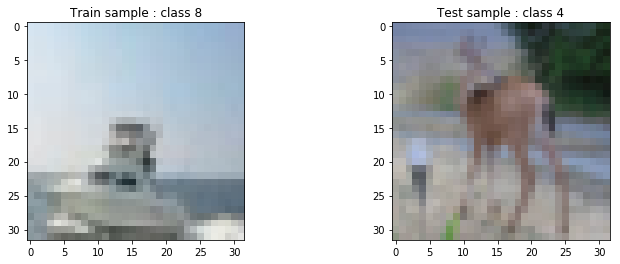

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(train_dp[0])
plt.title("Train sample : class %i" % train_dp[1])
plt.subplot(122)
plt.imshow(test_dp[0])
_ = plt.title("Test sample : class %i" % test_dp[1])

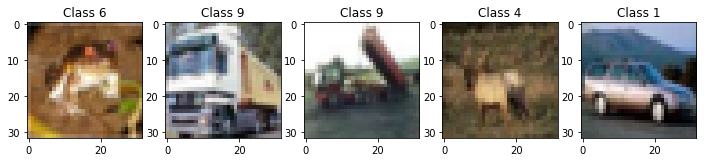

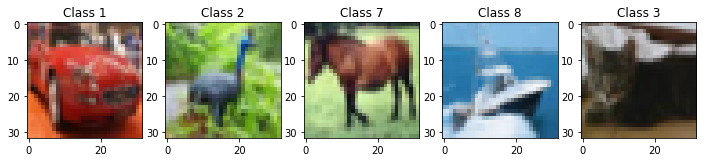

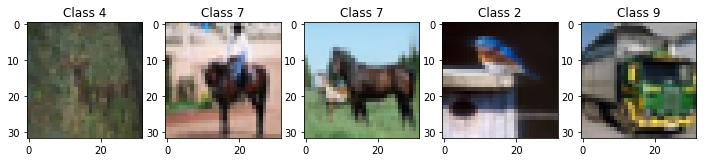

In [10]:
max_count = 15
n = 5
for i, (x, y) in enumerate(train_ds):
    
    if i % n == 0:
        plt.figure(figsize=(12, 4))
    
    plt.subplot(1, n, (i % n) + 1)
    plt.imshow(x)
    plt.title("Class %i" % y)
    
    max_count -= 1 
    if max_count == 0:
        break

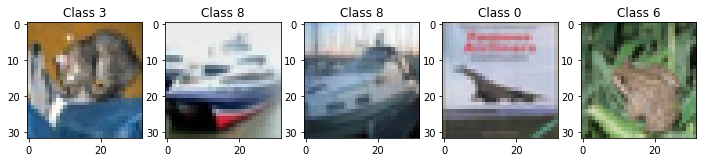

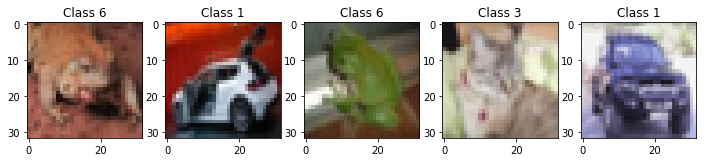

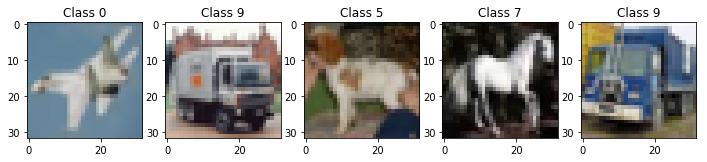

In [11]:
max_count = 15
n = 5
for i, (x, y) in enumerate(test_ds):
    
    if i % n == 0:
        plt.figure(figsize=(12, 4))
    
    plt.subplot(1, n, (i % n) + 1)
    plt.imshow(x)
    plt.title("Class %i" % y)
    
    max_count -= 1 
    if max_count == 0:
        break

## Custom dataset

Let's create a proxy dataset class to show an example of how to extend Dataset class on another data source. 

We have to simply reimplement two methods:
- `__len__`
- `__getitem__`


Let's suppose we need to work with CIFAR images of size 48 x 48. By default, torchvision CIFAR10 dataset returns a sample as a tuple of `PIL.Image.Image` and `int`. The following dataset returns samples as tuples of (`np.array`, `int`)

In [12]:
from PIL import Image
from torch.utils.data import Dataset

class ResizeDataset(Dataset):
    
    def __init__(self, ds, output_size=(32, 32)):        
        assert isinstance(ds, Dataset)        
        self.ds = ds
        self.output_size = output_size
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, index):
        x, y = self.ds[index]
        x = x.resize(self.output_size)
        return x, y
    

In [13]:
resized_train_ds = ResizeDataset(train_ds, output_size=(48, 48))
resized_test_ds = ResizeDataset(test_ds, output_size=(48, 48))

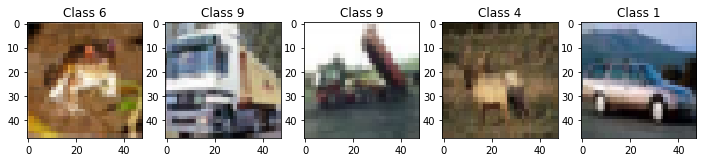

In [14]:
max_count = 5
n = 5
for i, (x, y) in enumerate(resized_train_ds):
    
    if i % n == 0:
        plt.figure(figsize=(12, 4))
    
    plt.subplot(1, n, (i % n) + 1)
    plt.imshow(x)
    plt.title("Class %i" % y)
    
    max_count -= 1 
    if max_count == 0:
        break

In a lot of examples of custom Dataset (even in `torchvision.datasets.CIFAR10`) data augmentation is incorporated in the dataset as callable object:
```
train_ds = torchvision.datasets.CIFAR10(root, train, transform=x_transform, target_transform=y_transform)

def __getitem__(self, index):
    ...
    if self.transform is not None:
            img = self.transform(img)
    ...
    if self.target_transform is not None:
        target = self.target_transform(target)

    return img, target
```

Let's create another proxy dataset that allows to apply transformations on samples (x) and targets (y)

In [15]:
class TransformedDataset(Dataset):
    
    def __init__(self, ds, x_transforms, y_transforms=None):
        assert isinstance(ds, Dataset)
        assert callable(x_transforms)
        if y_transforms is not None:
            assert callable(y_transforms)        
        self.ds = ds        
        self.x_transforms = x_transforms
        self.y_transforms = y_transforms
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, index):
        x, y = self.ds[index]       
        x = self.x_transforms(x)
        if self.y_transforms is not None:
            y = self.y_transforms(y)
        return x, y


## Pipeline of datasets

A typical dataflow pipeline looks like 
```
             [Training dataset: x, y]        [Test dataset: x, y?]
                        |                           |               
                      Split                         |
                        |                           |
   /--->[Train dataset]-.-[Val dataset]             |
   |           |                |                   | 
   |        shuffle             |                   |
   |           |                |                   |
   |    [Train Geom Aug]  [Test Geom Aug]     [Test Geom Aug]
   |           |                |                   |
   |    [Train Color Aug] [Test Color Aug]    [Test Color Aug]       
   |           |                |                   |
   |    [Type/Range Norm] [Type/Range Norm]   [Type/Range Norm]
   |           |                |                   |
   |           |                |                   |
   |      [To Batches]     [To Batches]        [To Batches]
   |           |                |                   |
   |       [Prefetch]       [Prefetch]          [Prefetch]
   |           |                |                   |
   \-----------/                |                   |
```

In the above schema, data augmentation is applied: 
- on x only for a classification task 
- on x, y (without color augmentations) for a segmentation task 

### Typical data augmentations

The library `torchvision` provides PIL-based base classes for data augmentation:
```
PIL.Image -> [torchvision.transforms] -> {PIL.Image, torch.Tensor}
```
#### Geometry 
- Affine:
    - Rotations
    - Scale
    - Translation
    - Shear
- Flip left/right
- Flip up/down
- Crop to size

#### Color
- ColorJitter
- Brightness
- Contrast

A transform is class that implements `__call__` operator

In [16]:
from torchvision.transforms import Compose, Normalize, ToTensor, Lambda
from torchvision.transforms import RandomCrop

Here we use transformations using opencv

In [17]:
from common.imgaug import ToNumpy, RandomOrder, RandomChoice, RandomFlip, RandomAffine, ColorJitter

In [18]:
mean_val = [0.5] * 3  # RGB
std_val = [0.5] * 3  # RGB

train_transforms = Compose([
    # From 48 -> 42
    RandomCrop(42),
    ToNumpy(),
    # Geometry
    RandomChoice([
        RandomAffine(rotation=(-60, 60), scale=(0.95, 1.05), translate=(0.05, 0.05)),
        RandomFlip(proba=0.5, mode='h'),
        RandomFlip(proba=0.5, mode='v'),        
    ]),    
    # To Tensor (float, CxHxW, [0.0, 1.0]) + Normalize
    ToTensor(),
    # Color
    ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    Normalize(mean_val, std_val)
])
  

test_transforms = Compose([
    RandomCrop(32),
    ToNumpy(),    
    # Geometry
    RandomChoice([
        RandomAffine(rotation=(-60, 60), scale=(0.95, 1.05), translate=(0.05, 0.05)),
        RandomFlip(proba=0.5, mode='h'),
        RandomFlip(proba=0.5, mode='v'),        
    ]),        
    # To Tensor (float, CxHxW, [0.0, 1.0])  + Normalize
    ToTensor(),
    # Color
    ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    Normalize(mean_val, std_val)
])

In [19]:
data_aug_train_ds = TransformedDataset(resized_train_ds, x_transforms=train_transforms)
data_aug_val_ds = TransformedDataset(resized_train_ds, x_transforms=test_transforms)

In [20]:
from common.image_utils import scale_percentile

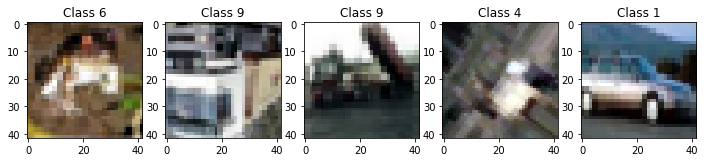

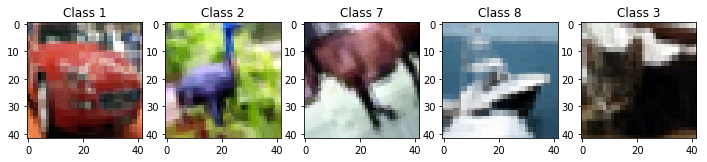

In [21]:
max_count = 10
n = 5
for i, (x, y) in enumerate(data_aug_train_ds):
    
    if i % n == 0:
        plt.figure(figsize=(12, 4))
    
    plt.subplot(1, n, (i % n) + 1)
    plt.imshow(scale_percentile(x.numpy().transpose([1, 2, 0])))
    plt.title("Class %i" % y)
    
    max_count -= 1 
    if max_count == 0:
        break

## Data sampler and loader
 
Split data on K stratified folds and load it using multiple processes

In [22]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [23]:
from sklearn.model_selection import StratifiedKFold

ds = resized_train_ds

n_samples = len(ds)
X = np.zeros(n_samples)
Y = np.zeros(n_samples)
for i, (_, label) in enumerate(ds):
    Y[i] = label

kfolds_train_indices = []
kfolds_val_indices = []
    
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
for train_indices, val_indices in skf.split(X, Y):
    kfolds_train_indices.append(train_indices)
    kfolds_val_indices.append(val_indices)    

In [24]:
kfold_samplers = []
for train_indices, val_indices in zip(kfolds_train_indices, kfolds_val_indices):
    kfold_samplers.append({"train": SubsetRandomSampler(train_indices), 
                           "val": SubsetRandomSampler(val_indices)})

We work with the first split:
- First split training random data sampler : `kfold_samplers[0]["train"]`
- First split validation random data sampler : `kfold_samplers[0]["val"]`


Let's visualize several epochs of reduced training dataset with augmentations

In [25]:
# For visualization purposes:
n_samples = 10
kfold_samplers = []
for train_indices, val_indices in zip(kfolds_train_indices, kfolds_val_indices):
    kfold_samplers.append({"train": SubsetRandomSampler(train_indices[:n_samples]), 
                           "val": SubsetRandomSampler(val_indices[:n_samples])})

In [26]:
split_index = 0 

train_batches_ds = DataLoader(data_aug_train_ds, 
                              batch_size=4, 
                              sampler=kfold_samplers[split_index]["train"], num_workers=4, drop_last=True)
val_batches_ds = DataLoader(data_aug_val_ds, 
                            batch_size=4, 
                            sampler=kfold_samplers[split_index]["val"], num_workers=4, drop_last=True)

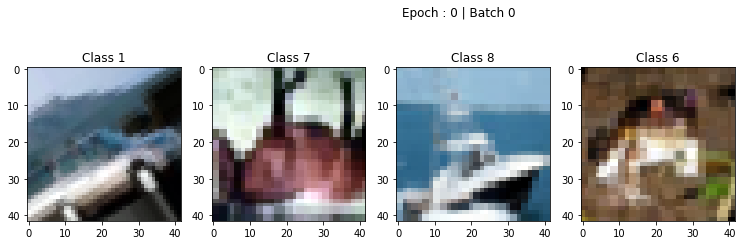

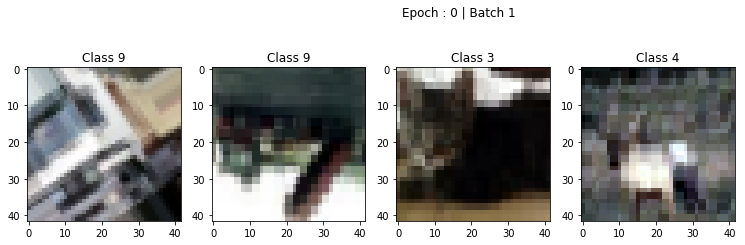

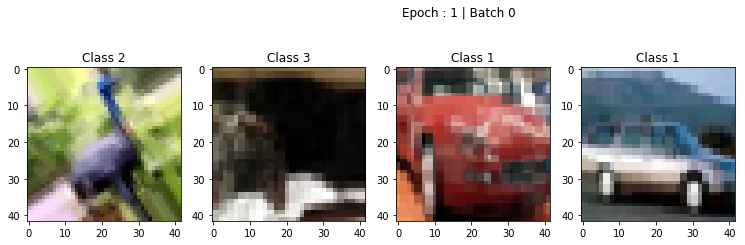

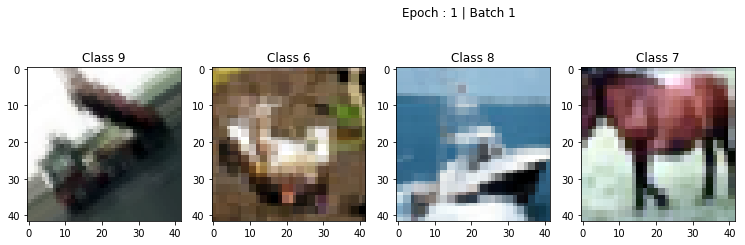

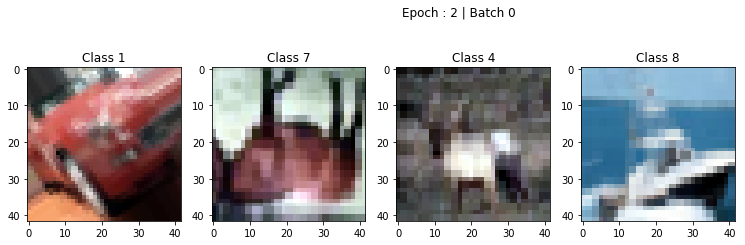

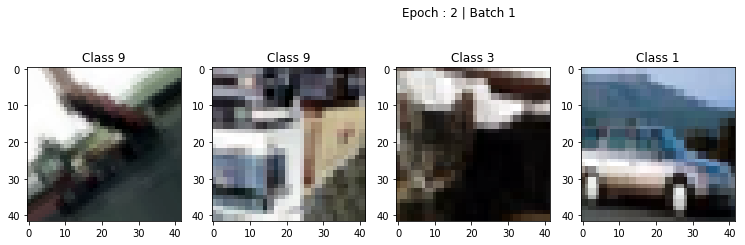

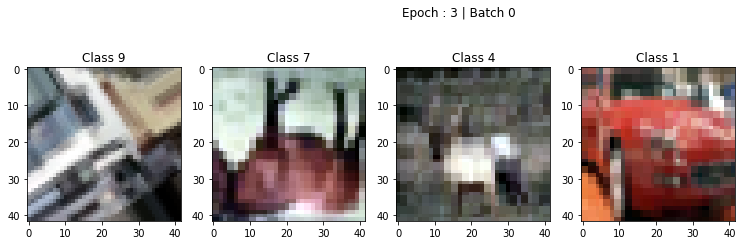

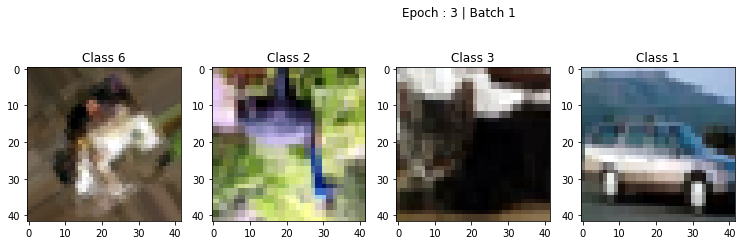

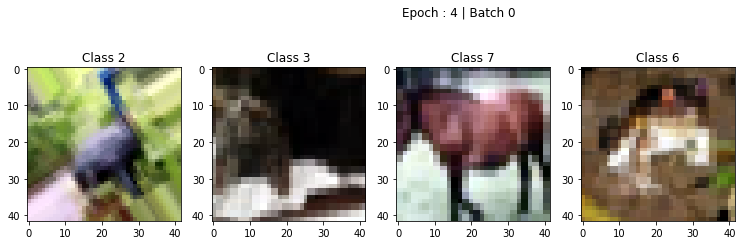

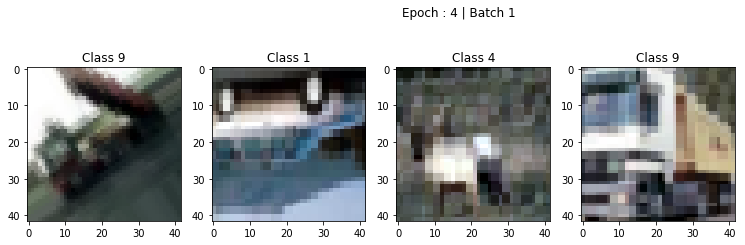

In [27]:
max_epochs = 5
n = 5

for epoch in range(max_epochs): 
    for i, (batch_x, batch_y) in enumerate(train_batches_ds):

        plt.figure(figsize=(16, 4))
        plt.suptitle("Epoch : %i | Batch %i" % (epoch, i))
        for j in range(len(batch_x)):    
            if j > 0 and j % n == 0:
                plt.figure(figsize=(16, 4))

            x = batch_x[j, ...]
            y = batch_y[j, ...]
            plt.subplot(1, n, (j % n) + 1)
            plt.imshow(scale_percentile(x.numpy().transpose([1, 2, 0])))
            plt.title("Class %i" % y)

Now let's visualize several batches of a single epoch of the whole training dataset

In [28]:
kfold_samplers = []
for train_indices, val_indices in zip(kfolds_train_indices, kfolds_val_indices):
    kfold_samplers.append({"train": SubsetRandomSampler(train_indices), 
                           "val": SubsetRandomSampler(val_indices)})

In [29]:
split_index = 0 

train_batches_ds = DataLoader(data_aug_train_ds, 
                              batch_size=64, 
                              sampler=kfold_samplers[split_index]["train"], num_workers=4, drop_last=True)
val_batches_ds = DataLoader(data_aug_val_ds, 
                            batch_size=64, 
                            sampler=kfold_samplers[split_index]["val"], num_workers=4, drop_last=True)

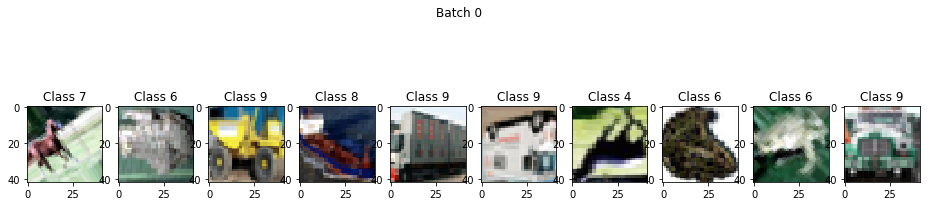

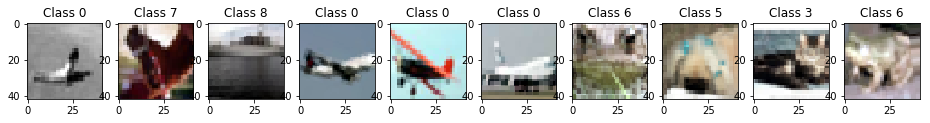

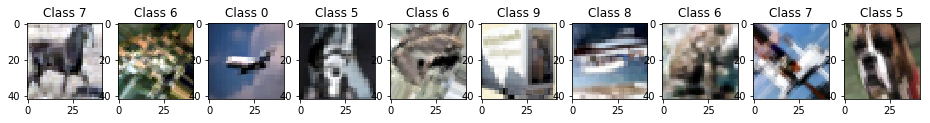

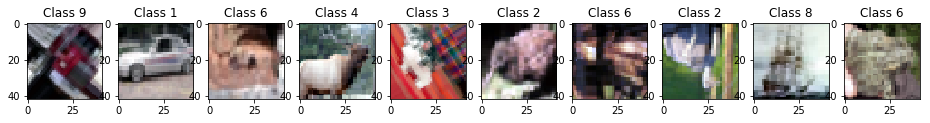

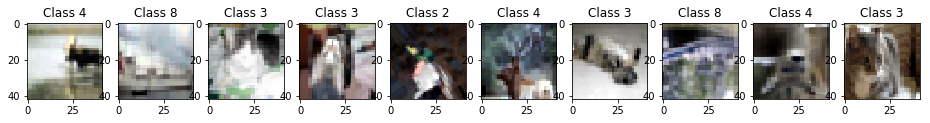

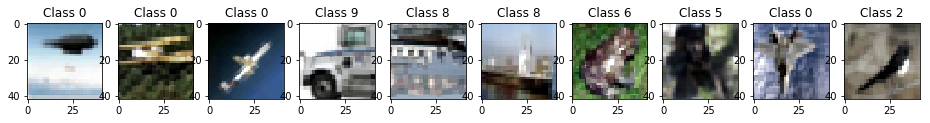

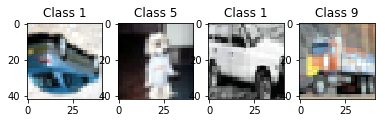

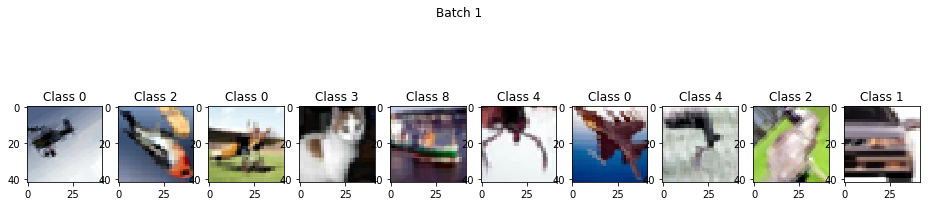

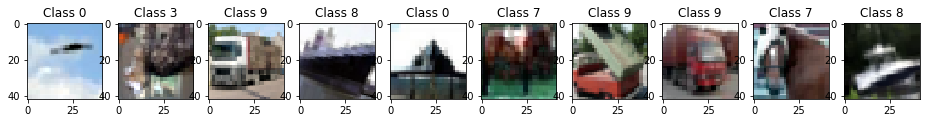

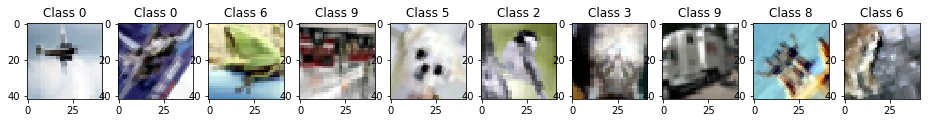

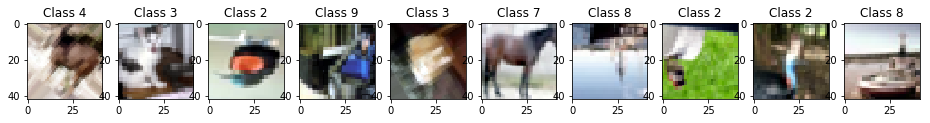

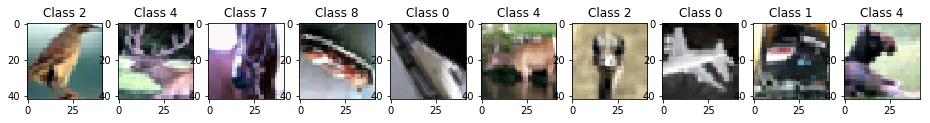

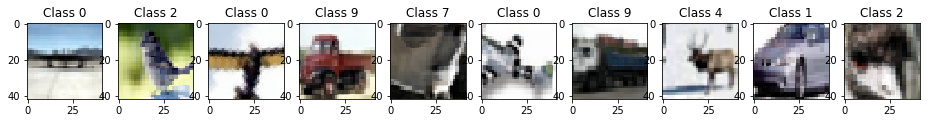

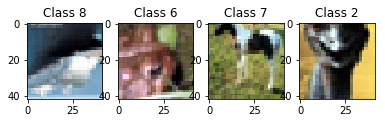

In [30]:
max_count = 2
n = 10

for i, (batch_x, batch_y) in enumerate(train_batches_ds):
    
    plt.figure(figsize=(16, 4))
    plt.suptitle("Batch %i" % i)
    for j in range(len(batch_x)):    
        if j > 0 and j % n == 0:
            plt.figure(figsize=(16, 4))
        
        x = batch_x[j, ...]
        y = batch_y[j, ...]
        plt.subplot(1, n, (j % n) + 1)
        plt.imshow(scale_percentile(x.numpy().transpose([1, 2, 0])))
        plt.title("Class %i" % y)
    
    max_count -= 1 
    if max_count == 0:
        break

Let's measure the time need to loop over the whole dataset

In [31]:
len(train_batches_ds), len(val_batches_ds)

(625, 156)

In [32]:
%%timeit -r1 -n3

for i, (batch_x, batch_y) in enumerate(train_batches_ds):
    pass

3 loops, best of 1: 5.34 s per loop


In [33]:
%%timeit -r1 -n3

for i, (batch_x, batch_y) in enumerate(val_batches_ds):
    pass

3 loops, best of 1: 1.27 s per loop


Class distibution

In [34]:
from collections import defaultdict, Hashable
total_y_stats = defaultdict(int)
cnt = 0
display_freq = 10
display_total = True

for i, (batch_x, batch_y) in enumerate(train_batches_ds):
    y_stats = defaultdict(int)
    for y in batch_y:
        if isinstance(y, Hashable):
            total_y_stats[y] += 1 
            y_stats[y] += 1
                    
    if (cnt % display_freq) == 0:
        print("\n%i | Labels counts: " % cnt)
        print("  current: | ", end='')
        for k in y_stats:
            print("'{}': {} |".format(str(k), y_stats[k]), end=' ')
        print('')
        if display_total:
            print("    total: | ", end='')
            for k in total_y_stats:
                print("'{}': {} |".format(str(k), total_y_stats[k]), end=' ')
            print('')                    
    cnt += 1



0 | Labels counts: 
  current: | '0': 8 | '1': 4 | '2': 6 | '3': 6 | '4': 10 | '5': 4 | '6': 7 | '7': 7 | '8': 6 | '9': 6 | 
    total: | '0': 8 | '1': 4 | '2': 6 | '3': 6 | '4': 10 | '5': 4 | '6': 7 | '7': 7 | '8': 6 | '9': 6 | 

10 | Labels counts: 
  current: | '0': 5 | '1': 5 | '2': 11 | '3': 10 | '4': 4 | '5': 7 | '6': 6 | '7': 6 | '8': 8 | '9': 2 | 
    total: | '0': 54 | '1': 71 | '2': 78 | '3': 75 | '4': 74 | '5': 65 | '6': 74 | '7': 71 | '8': 70 | '9': 72 | 

20 | Labels counts: 
  current: | '0': 10 | '1': 6 | '2': 8 | '3': 9 | '4': 2 | '5': 9 | '6': 5 | '7': 6 | '8': 6 | '9': 3 | 
    total: | '0': 132 | '1': 126 | '2': 148 | '3': 138 | '4': 132 | '5': 126 | '6': 132 | '7': 136 | '8': 145 | '9': 129 | 

30 | Labels counts: 
  current: | '0': 6 | '1': 7 | '2': 8 | '3': 7 | '4': 4 | '5': 8 | '6': 5 | '7': 6 | '8': 6 | '9': 7 | 
    total: | '0': 198 | '1': 197 | '2': 222 | '3': 206 | '4': 188 | '5': 174 | '6': 198 | '7': 196 | '8': 221 | '9': 184 | 

40 | Labels counts: 
  cu


330 | Labels counts: 
  current: | '0': 5 | '1': 7 | '2': 8 | '3': 7 | '4': 5 | '5': 4 | '6': 6 | '7': 10 | '8': 7 | '9': 5 | 
    total: | '0': 2141 | '1': 2152 | '2': 2096 | '3': 2112 | '4': 2144 | '5': 2081 | '6': 2137 | '7': 2104 | '8': 2113 | '9': 2104 | 

340 | Labels counts: 
  current: | '0': 9 | '1': 4 | '2': 4 | '3': 6 | '4': 6 | '5': 11 | '6': 3 | '7': 10 | '8': 7 | '9': 4 | 
    total: | '0': 2198 | '1': 2218 | '2': 2154 | '3': 2166 | '4': 2215 | '5': 2151 | '6': 2194 | '7': 2184 | '8': 2182 | '9': 2162 | 

350 | Labels counts: 
  current: | '0': 3 | '1': 10 | '2': 10 | '3': 6 | '4': 7 | '5': 4 | '6': 5 | '7': 5 | '8': 8 | '9': 6 | 
    total: | '0': 2253 | '1': 2280 | '2': 2225 | '3': 2232 | '4': 2267 | '5': 2228 | '6': 2262 | '7': 2245 | '8': 2246 | '9': 2226 | 

360 | Labels counts: 
  current: | '0': 7 | '1': 9 | '2': 5 | '3': 6 | '4': 6 | '5': 7 | '6': 2 | '7': 8 | '8': 7 | '9': 7 | 
    total: | '0': 2324 | '1': 2339 | '2': 2292 | '3': 2287 | '4': 2323 | '5': 2301 | 

## From CPU to GPU

To copy tensor from CPU to GPU, simply call `.cuda()` on the tensor:
```
t = t.cuda()
```

Here is a trick go directly to GPU (without CPU):
```
use_cuda = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
```


To choose a GPU, one can use `torch.cuda.device` context manager:
```
with torch.cuda.device(0):
    x = torch.cuda.Tensor(1) # GPU 0
```


> ### Use pinned memory buffers

> Host to GPU copies are much faster when they originate from pinned (page-locked) memory. CPU tensors and storages expose a `pin_memory()` method, that returns a copy of the object, with data put in a pinned region.

> Also, once you pin a tensor or storage, you can use asynchronous GPU copies. Just pass an additional `async=True` argument to a `cuda()` call. This can be used to overlap data transfers with computation.


References:
- [CUDA semantics](http://pytorch.org/docs/master/notes/cuda.html#best-practices)

In [35]:
!nvidia-smi --format=csv --query-gpu=memory.used

memory.used [MiB]
7039 MiB


In [36]:
t = torch.randn((32, 3, 512, 512)).cuda()
p = torch.randn((32, 3, 512, 512))

In [37]:
!nvidia-smi --format=csv --query-gpu=memory.used

memory.used [MiB]
7460 MiB


In [38]:
t.is_cuda, p.is_cuda

(True, False)

In [39]:
pp = p.pin_memory()

In [40]:
p.is_pinned(), pp.is_pinned(), pp.is_cuda

(False, True, False)

In [41]:
ppc = pp.cuda(async=True)
ppc.is_pinned(), ppc.is_cuda

(False, True)

In [42]:
!nvidia-smi --format=csv --query-gpu=memory.used

memory.used [MiB]
7556 MiB


Now, let's modify a little the previous dataflow pipeline to pass data on GPU:

In [43]:
from common.dataflow import OnGPUDataLoader

In [44]:
split_index = 0 

cuda_train_batches_ds = OnGPUDataLoader(data_aug_train_ds, 
                                        batch_size=64, 
                                        sampler=kfold_samplers[split_index]["train"], 
                                        num_workers=4, 
                                        drop_last=True, 
                                        pin_memory=True)
cuda_val_batches_ds = OnGPUDataLoader(data_aug_val_ds,
                                      batch_size=64, 
                                      sampler=kfold_samplers[split_index]["val"],
                                      num_workers=4, 
                                      drop_last=True)

In [45]:
!nvidia-smi --format=csv --query-gpu=memory.used

memory.used [MiB]
7556 MiB


In [46]:
for i, (batch_x, batch_y) in enumerate(cuda_train_batches_ds):
    print(batch_x.is_cuda, batch_y.is_cuda)
    break
    pass

True True


In [47]:
!nvidia-smi --format=csv --query-gpu=memory.used

memory.used [MiB]
7560 MiB


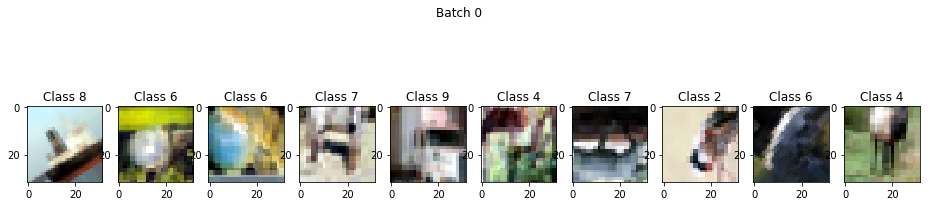

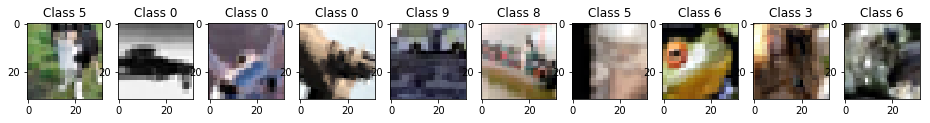

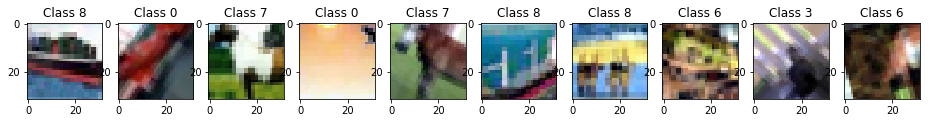

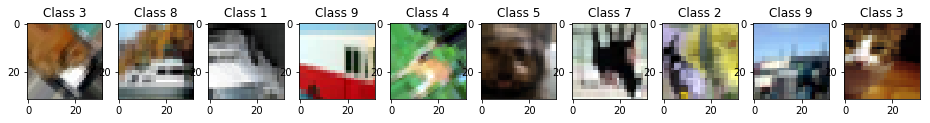

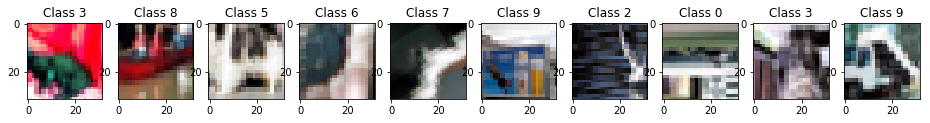

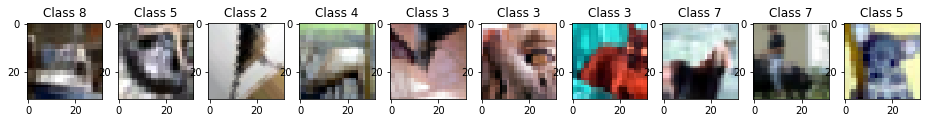

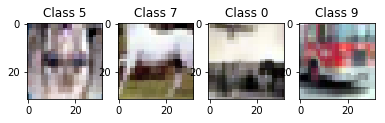

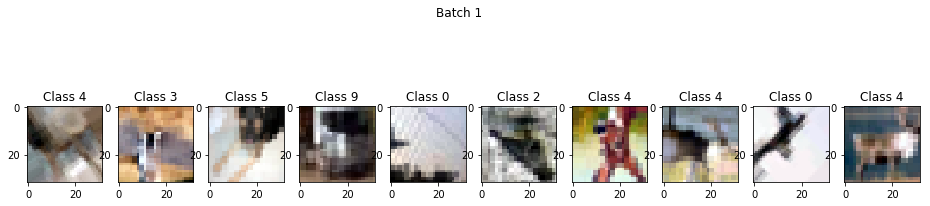

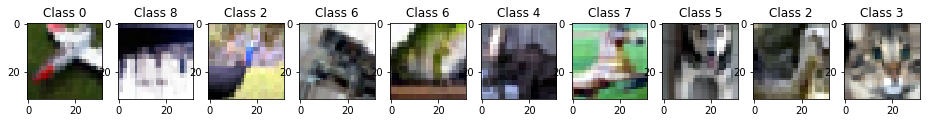

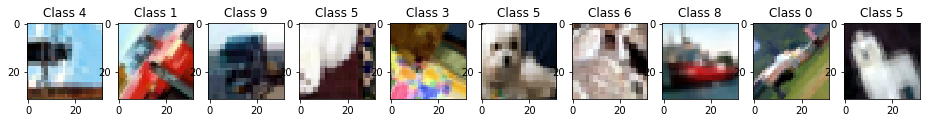

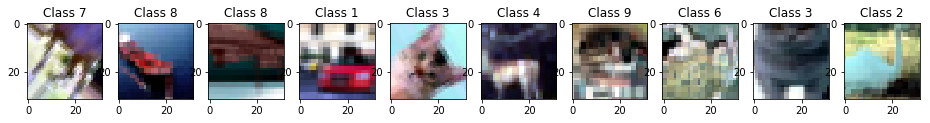

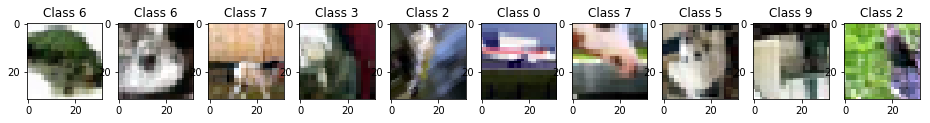

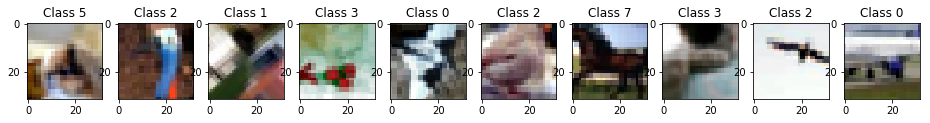

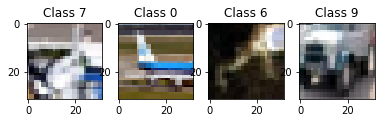

In [48]:
max_count = 2
n = 10

for i, (batch_x, batch_y) in enumerate(cuda_val_batches_ds):
    
    plt.figure(figsize=(16, 4))
    plt.suptitle("Batch %i" % i)
    for j in range(len(batch_x)):    
        if j > 0 and j % n == 0:
            plt.figure(figsize=(16, 4))
        
        x = batch_x[j, ...]
        y = batch_y[j, ...]
        plt.subplot(1, n, (j % n) + 1)
        plt.imshow(scale_percentile(x.cpu().numpy().transpose([1, 2, 0])))
        plt.title("Class %i" % y)
    
    max_count -= 1 
    if max_count == 0:
        break

Let's measure time elapsed to loop on the whole dataset with a basic operation on training images

In [49]:
%%timeit -r1 -n3

for i, (batch_x, batch_y) in enumerate(cuda_train_batches_ds):
    s = torch.sum(batch_x, dim=1)

3 loops, best of 1: 5.67 s per loop
